In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

/Users/sennedirkx/.local/share/virtualenvs/src-3aXnpWCD/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [3]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 1358


In [4]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [7]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [8]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [89]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.nz, 64, (3,2), 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, (2,2), 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 10, (2,1), 2, bias=False),
            #nn.Tanh()
        )

    def forward(self, x, temp, hard):
        x = self.main(x)
        x = gumbel_softmax(x, temp, hard)
        return x

In [90]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 10, kernel_size=(2, 1), stride=(2, 2), bias=False)
  )
)


In [91]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

conv1 = nn.Conv2d(10, 16, 4, 1, bias=False)
conv2 = nn.Conv2d(16, 32, 4, 1, bias=False)
conv3 = nn.Conv2d(32, 48, 4, 1, bias=False)
conv4 = nn.Conv2d(48, 64, (3,1), 1, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(64*5*2, 128)
print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = conv4(x)
print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 128, 1, 1)
deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
deconv2 = nn.ConvTranspose2d(64, 32, (2,2), 1, bias=False)
deconv3 = nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False)
deconv4 = nn.ConvTranspose2d(16, 10, (2,1),2, bias=False)
y = deconv1(test_latent)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)
y = deconv4(y)
print(y.shape)

dis
torch.Size([1, 16, 13, 8])
torch.Size([1, 32, 10, 5])
torch.Size([1, 48, 7, 2])
torch.Size([1, 64, 5, 2])
torch.Size([1, 640])
torch.Size([1, 128])
gen
torch.Size([1, 64, 3, 2])
torch.Size([1, 32, 4, 3])
torch.Size([1, 16, 8, 6])
torch.Size([1, 10, 16, 11])


In [92]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 16, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/1 + 1 = 13, W = (in+2P-k)/S + 1 = (11+0-4)/1 + 1 = 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (13+0-4)/1 + 1 = 10, W = (in+2P-k)/S + 1 = (8+0-4)/1 + 1 = 5
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, (3,1), 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*5*2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [93]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1280, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=16, bias=True)
    (16): ReLU()
   

In [94]:

temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [95]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, 1,1).to(device)

In [96]:
from pysdd.sdd import Vtree, SddManager
from pathlib import Path
current_folder = globals()['_dh'][0]

def import_sdd(name):
    vtree_file = "./" + name + ".vtree"
    vtree = Vtree.from_file(vtree_file)
    manager = SddManager.from_vtree(vtree)
    root = manager.read_sdd_file(bytes(Path(current_folder) / (name + ".sdd")))
    return root

def create_computation_graph(root, symbols):
    if not root.is_decision():
        if root.is_literal():
            if root.literal < 0:
                #print(0)
                return 1 - symbols[abs(root.literal)]
                #return torch.add(torch.ones(shape, requires_grad=True), - symbols[abs(root.literal)])
            elif root.literal > 0:
                #print(1)
                return symbols[root.literal]
            else:
                #print(2)
                return 1
        elif root.is_false():
            #print(3)
            return 0
            #return symbols[1] * 0
        elif root.is_true():
            #print(4)
            return 1
            #return symbols[1] * 0 + torch.ones(shape)
        else:
            return "BRUH"
    else:
        summation = 0
        for elem in root.elements():
            elem0_graph = create_computation_graph(elem[0], symbols)
            elem1_graph = create_computation_graph(elem[1], symbols)
            elem_mult = elem0_graph * elem1_graph
            summation += elem_mult
        #print(summation)
        return summation
    
def create_test_graph(root, symbols):
    shape = symbols[1].shape
    if not root.is_decision():
        if root.is_literal():
            if root.literal < 0:
                #print(0)
                #return torch.ones(shape, requires_grad=True) - symbols[abs(root.literal)]
                return torch.ones(shape) - symbols[abs(root.literal)]
            elif root.literal > 0:
                #print(1)
                return symbols[root.literal]
            else:
                #print(2)
                return symbols[4]
        elif root.is_false():
            #print(3)
            #return torch.ones(shape)
            #return torch.mul(symbols[4], 1 - symbols[4])
            #return symbols[4]
            return torch.zeros(shape)
        elif root.is_true():
            #print(4)
            return torch.ones(shape)
            #return symbols[4]
        else:
            return "BRUH"
    else:
        summation = torch.zeros(shape, requires_grad=True)
        for elem in root.elements():
            elem0_graph = create_test_graph(elem[0], symbols)
            #print('0', elem0_graph.shape)
            elem1_graph = create_test_graph(elem[1], symbols)
            #print('1', elem1_graph.shape)
            elem_mult = torch.mul(elem0_graph, elem1_graph)
            #print('mult', elem_mult.shape)
            summation = torch.add(summation, elem_mult)
        result = torch.minimum(summation, torch.ones(shape))
        return result

def satisfaction(output):
    sdd = import_sdd("constraints/basic_constraint")
    #print(traverse_tree(sdd))
    #print(analyze_tree_with_vars(sdd, [0, 1, 1, 1, 1] + [0, 0, 0, 1]))
    door_left = torch.prod(output[:, 6, 7:9, 0], 1)
    door_right = torch.prod(output[:, 6, 7:9, 10], 1)
    door_top = torch.prod(output[:, 6, 0, 4:7], 1)
    door_bottom = torch.prod(output[:, 6, 15, 4:7], 1)
    
    wall_left = torch.prod(output[:, 8, :, 0], 1)
    wall_right = torch.prod(output[:, 8, :, 10], 1)
    wall_top = torch.prod(output[:, 8, 0, :], 1)
    wall_bottom = torch.prod(output[:, 8, 15, :], 1)
    
    batch_size = output.shape[0]
    eps = 1e-7
    
    constraint_vals = [None, door_left, door_right, door_top, door_bottom, wall_left, wall_right, wall_top, wall_bottom]
    #loss = create_computation_graph(sdd, constraint_vals)
    #print(loss)
    #loss = torch.sum(loss)/batch_size + eps
    #print(loss)
    
    #loss = 64.0 - torch.sum(door_left) + eps
    loss = create_test_graph(sdd, constraint_vals)
    #print("example satisfaction", loss)
    loss = torch.sum(loss)/batch_size + eps
    #print("total satisfaction", loss)
    
    
    #sum1 = torch.sum(output, dim=3)
    #sum2 = torch.sum(sum1, dim=2)
    #loss = torch.sum(output)
    #elem1 = sum2[:,0] * 10
    #elem2 = sum2[:,1:]
    
    #loss = torch.sum(elem1) + torch.sum(elem2)
    return loss

def satisfaction2(output):
    sdd = import_sdd("constraints/test_constraint")
    #print(traverse_tree(sdd))
    #print(analyze_tree_with_vars(sdd, [0, 1, 1, 1, 1] + [0, 0, 0, 1]))
    
    #wall_left = torch.mean(torch.prod(output[:, 8, :, 0], 1))
    #wall_right = torch.mean(torch.prod(output[:, 8, :, 10], 1))
    #wall_top = torch.mean(torch.prod(output[:, 8, 0, :], 1))
    #wall_bottom = torch.mean(torch.prod(output[:, 8, 15, :], 1))
    
    
    batch_size = output.shape[0]
    eps = 1e-7
    
    constraint_vals = [None]
    for x in range(11):
        tmp = torch.mean(output[:, 8, 0, x])
        constraint_vals.append(tmp)
        tmp = torch.mean(output[:, 8, 15, x])
        constraint_vals.append(tmp)
    for y in range(1,15):
        tmp = torch.mean(output[:, 8, y, 0])
        constraint_vals.append(tmp)
        tmp = torch.mean(output[:, 8, y, 10])
        constraint_vals.append(tmp)
    
    #b = torch.Tensor(50)
    
    #torch.cat(constraint_vals[1:], out=b)
    #print(torch.mean(b))
    #print(constraint_vals)
    
    #loss = create_computation_graph(sdd, constraint_vals)
    #print(loss)
    #loss = torch.sum(loss)/batch_size + eps
    #print(loss)
    
    #manual_loss = 0.0
    #for i in range(1, len(constraint_vals)):
    #    manual_loss *= constraint_vals[i]
    #
    #return manual_loss
    
    
    #loss = 64.0 - torch.sum(door_left) + eps
    loss = create_computation_graph(sdd, constraint_vals)
    #print("example satisfaction", loss)
    #loss = loss + eps
    #print("total satisfaction", loss)
    
    
    #sum1 = torch.sum(output, dim=3)
    #sum2 = torch.sum(sum1, dim=2)
    #loss = torch.sum(output)
    #elem1 = sum2[:,0] * 10
    #elem2 = sum2[:,1:]
    
    #loss = torch.sum(elem1) + torch.sum(elem2)
    return loss
    
    
def semantic_loss(output):
    loss = satisfaction2(output)
    #print("satisfaction", loss)
    
    #loss = -torch.log(loss)
    #print("Regular loss", loss)
    
    loss = torch.tensor(1.0) - loss
    return loss

In [97]:
gan_criterion = nn.BCELoss()
sl_lambda = 1
def can_loss(level):
    loss = sl_lambda * semantic_loss(level)
    #print(loss.item())
    return loss

In [199]:
from pylon.constraint import constraint
from pylon.brute_force_solver import SatisfactionBruteForceSolver
from pylon.circuit_solver import SemanticLossCircuitSolver

def xor(y):
    print("y", y.shape)
    return y[:, 0] != y[:, 1] and y[:, 1] != y[:, 2]

xor_cons = constraint(xor, SatisfactionBruteForceSolver())

def test_constraint(output):
    #print("output", output.shape)
    #print("output", output)
    ones = torch.ones(output.shape)
    
    result = torch.tensor([True]*output.shape[0])
    for i in range(output.shape[1]):
        result = torch.logical_and(result, output[:, i] == ones[:, i])
    return result

test_cons = constraint(test_constraint, SatisfactionBruteForceSolver())

def circuit_constraint(output):
    #print("output", output.shape)
    #print("output", output)
    return torch.logical_and(output[:,0] == 1, output[:,1] == 1)

circuit_cons = constraint(circuit_constraint, SemanticLossCircuitSolver())

In [201]:
rnd = torch.ones(64, 10, 16, 11)
out = (rnd>=0.2).float()
out.requires_grad = True

testy = torch.rand(2, 3, 2)
#testyr = xor_cons(testy)

out = torch.ones(64, 10, 16, 11)
out.requires_grad = True
selected = out[:, 8, 0, :].unsqueeze(2)
opposite = 1 - selected
third_tensor = torch.cat((selected, opposite), 2)
print("input", third_tensor)
#print("input", third_tensor)
#result_loss = test_cons(third_tensor)
#print(result_loss)
#print(torch.sum(generator.main[0].weight.grad))
#result_loss.backward()
randy = torch.rand(10,2)
print(randy)
third_tensor_one = third_tensor[0]
only_one_constraint = constraint(only_one, SemanticLossCircuitSolver())
test_loss = only_one_constraint(randy)
circ_loss = circuit_constraint(third_tensor_one)
print(circ_loss)
#optim_g.step()
#print(torch.sum(generator.main[0].weight.grad))

input tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        ...,

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]]], grad_fn=<CatBackward0>)
tensor([[0.4377, 0.1576],
        [0.5800, 0.0391],
        [0.4917, 0.4134],
        [0.3893, 0.8605],
        [0.8230, 0.6404],
        [0.1782, 0.3293],
        [0.4436, 0.7

In [173]:
from pylon.tnorm_solver import *
from pylon.sampling_solver import WeightedSamplingSolver
from pylon.circuit_solver import SemanticLossCircuitSolver


def get_solvers(num_samples):
    return [SemanticLossCircuitSolver()]


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 20)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x.reshape(10, 2)


def train(constraint=None, epoch=200):

    net = Net()
    X, y = get_mnist_data()
    optimizer = optim.Adadelta(net.parameters(), lr=1.0)

    for i in range(epoch):

        optimizer.zero_grad()

        output = net(X)
        loss = F.cross_entropy(output[:, 1].reshape(1, 10), y)
        
        print(output)
        if constraint:
            loss += constraint(output)

        loss.backward()
        optimizer.step()

    return net


def only_one(x):
    # return sum(x) == 1
    return (x[0] == 1 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 1 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 1 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 1 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 1 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 1 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 1 and x[7] == 0 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 1 and x[8] == 0 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 1 and x[9] == 0) or\
        (x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] ==
         0 and x[5] == 0 and x[6] == 0 and x[7] == 0 and x[8] == 0 and x[9] == 1)


def test_only_one_mnist():

    X, y = get_mnist_data()

    for solver in get_solvers(num_samples=200):
        only_one_constraint = constraint(only_one, solver)
        net = train(only_one_constraint)

        assert(torch.argmax(torch.softmax(net(X), dim=-1), dim=-1).sum().item() == 1)


def get_mnist_data():
    X = torch.tensor([[[
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242,  0.2249,  1.5996,  2.7960,  1.5996,  0.2122, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         0.1867,  2.6051,  2.7833,  2.7833,  2.7833,  2.5924, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.2631,
         2.4651,  2.7960,  2.7833,  2.6178,  2.5415,  2.7833,  0.3013,
         -0.3478, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.2969,  0.3395,  2.4269,
         2.7833,  2.7960,  2.7833,  2.1469,  0.6450,  2.7833,  2.7960,
         1.1286, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242,  1.6505,  2.7833,  2.7833,
         2.7833,  2.7960,  2.7833,  2.7833,  0.7977,  1.9814,  2.7960,
         1.7014, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242,  0.2249,  2.6051,  2.7960,  2.7960,
         1.9942,  1.0268,  2.7960,  2.4778,  0.1740,  0.5813,  2.8215,
         1.7141, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242,  0.1867,  2.6051,  2.7833,  2.7833,  1.8541,
         -0.2715,  0.5304,  1.1159, -0.1569, -0.4242, -0.4242,  2.7960,
         2.6687,  0.2122, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242,  0.0595,  1.6759,  2.7960,  2.5415,  2.2233,  0.6450,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  2.7960,
         2.7833,  1.6759, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.3351,  1.8414,  2.7833,  2.6306,  0.4795, -0.1824, -0.0678,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  2.7960,
         2.7833,  2.0578, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         0.3013,  2.7833,  2.7833,  0.3777, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  2.7960,
         2.7833,  2.0578, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         2.0960,  2.7960,  1.9942, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  2.8215,
         2.7960,  2.0705, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.5431,
         2.7069,  2.7833,  1.0013, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  2.7960,
         2.7833,  1.4596, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6577,
         2.7833,  2.5033, -0.1060, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.3351,  1.2941,  2.7960,
         1.9432, -0.2715, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6577,
         2.7833,  2.4142, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.3351,  1.2432,  2.7833,  2.4396,
         0.4795, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6577,
         2.7833,  1.4214, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242,  0.1867,  1.6759,  2.7833,  1.7778, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6704,
         2.7960,  2.4396, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242,  1.0268,  2.6051,  2.7960,  1.6378, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6577,
         2.7833,  2.7451,  1.4341,  0.1867, -0.0551,  0.6577,  1.8414,
         2.4396,  2.7960,  2.4142,  1.7014,  0.2886, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.6577,
         2.7833,  2.7833,  2.7833,  2.4906,  2.3124,  2.7833,  2.7833,
         2.7833,  2.0705,  1.2305, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.0678,
         2.1087,  2.7833,  2.7833,  2.7960,  2.7833,  2.7833,  2.5415,
         1.4214, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.1060,  1.2050,  2.7833,  2.7960,  2.7833,  1.3705,  0.0467,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242]]]])
    y = torch.tensor([0])

    return X, y

In [174]:
test_only_one_mnist()

tensor([[ 0.1907,  0.0041],
        [-0.2119, -0.0994],
        [ 0.2577, -0.0801],
        [-0.2565,  0.2603],
        [-0.0854, -0.3053],
        [ 0.0259, -0.2777],
        [ 0.0753, -0.1432],
        [-0.2062, -0.1720],
        [-0.1809,  0.0126],
        [-0.1855,  0.3200]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.0814, -0.0202],
        [ 0.0079,  0.0767],
        [ 0.0890,  0.0178],
        [-0.0094,  0.0769],
        [-0.0632, -0.0063],
        [ 0.0600, -0.0511],
        [ 0.0706, -0.0509],
        [-0.0628, -0.0955],
        [-0.0215,  0.0346],
        [ 0.0469,  0.0440]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.0944, -0.0097],
        [ 0.0174,  0.0668],
        [ 0.0992,  0.0073],
        [ 0.0039,  0.0637],
        [-0.0527, -0.0169],
        [ 0.0749, -0.0661],
        [ 0.0802, -0.0608],
        [-0.0538, -0.1047],
        [-0.0136,  0.0257],
        [ 0.0606,  0.0298]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.8984,  8.6980],
        [ 1.2448, -5.7108],
        [ 5.8092, -1.8920],
        [-1.5528, -5.5792],
        [ 1.4615, -2.4326],
        [ 3.3322, -1.4413],
        [ 1.3001, -2.8507],
        [ 2.2158, -5.4398],
        [ 2.7909, -3.1754],
        [ 1.9724, -3.0563]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 1.0465,  8.6201],
        [ 1.3068, -5.2647],
        [ 5.5623, -1.6407],
        [-1.4631, -5.5033],
        [ 1.6821, -2.7889],
        [ 3.1208, -1.0109],
        [ 1.4784, -3.1954],
        [ 1.6158, -4.8541],
        [ 2.2361, -2.9317],
        [ 1.1355, -3.0050]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.6350,  16.6751],
        [  3.3542, -10.5848],
        [ 11.2037,  -4.2894],
        [ -2.3454, -11.1691],
        [  3.7492,  -6.1254],
        [  7.1294,  -3.0610],
        [  3.9420,  -6.6359],
        [  2.6602,  -9.6546],
        [  4.0356,  -6.5192],
        [  2.8050,  -7.4440]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.7634,  15.5439],
        [  3.1051,  -9.8730],
        [ 10.4487,  -3.8575],
        [ -2.3626, -10.3504],
        [  3.7741,  -5.7155],
        [  6.4892,  -2.4385],
        [  3.7386,  -6.3716],
        [  2.5523,  -8.9179],
        [  3.8323,  -6.0570],
        [  2.4280,  -6.9857]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.5694,  14.7607],
        [  3.0154, -10.3406],
        [ 10.6699,  -4.3587],
        [ -1.3808, -11.5359],
        [  4.3891,  -6.5016],
        [  6.9653,  -3.3040],
        [  4.3519,  -6.8341],
        [  3.1937,  -9.6320],
        [  4.6556,  -5.9740],
        [  4.0764,  -7.5243]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  1.6871,  16.2132],
        [  3.1381, -10.5001],
        [ 11.4712,  -4.1720],
        [ -2.3108, -11.6677],
        [  4.0282,  -6.7709],
        [  6.8711,  -2.4699],
        [  4.1535,  -7.2981],
        [  3.2526,  -9.3760],
        [  4.5702,  -6.7055],
        [  2.6380,  -7.3676]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.3260,  14.7117],
        [  3.1455,  -9.6506],
        [ 10.0742,  -4.1573],
        [ -1.7823, -10.4054],
        [  3.7597,  -5.7578],
        [  6.8905,  -3.1930],
        [  3.8513,  -6.1138],
        [  2.4059,  -8.9838],
        [  3.8290,  -5.9713],
        [  3.0634,  -7.1875]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.5235,  14.5251],
        [  2.8045,  -9.5816],
        [ 10.3811,  -4.6959],
        [ -1.2680, -11.0873],
        [  3.7388,  -6.4200],
        [  7.6035,  -3.9687],
        [  4.1282,  -6.6974],
        [  2.1799,  -8.9480],
        [  3.8540,  -6.4211],
        [  3.5631,  -7.2288]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.4388,  13.1959],
        [  2.8760,  -9.6198],
        [  9.6703,  -4.1778],
        [ -0.6640, -10.9565],
        [  3.9834,  -6.1089],
        [  6.7989,  -3.6916],
        [  4.0553,  -6.2340],
        [  3.0276,  -9.2651],
        [  4.6688,  -5.5890],
        [  4.2875,  -6.9903]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.1493,  0.0529],
        [ 0.0777,  0.0063],
        [ 0.1591, -0.0529],
        [ 0.0615,  0.0049],
        [ 0.0100, -0.0797],
        [ 0.1290, -0.1235],
        [ 0.1426, -0.1229],
        [ 0.0083, -0.1674],
        [ 0.0490, -0.0368],
        [ 0.1151, -0.0257]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.1564,  0.0603],
        [ 0.0847, -0.0009],
        [ 0.1663, -0.0601],
        [ 0.0683, -0.0020],
        [ 0.0171, -0.0870],
        [ 0.1357, -0.1305],
        [ 0.1497, -0.1300],
        [ 0.0152, -0.1744],
        [ 0.0560, -0.0438],
        [ 0.1217, -0.0325]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.4089,  18.2227],
        [  4.0271, -11.7997],
        [ 12.4359,  -5.3666],
        [ -1.8317, -13.2179],
        [  4.6753,  -7.3917],
        [  8.9049,  -4.3775],
        [  4.9085,  -7.6657],
        [  2.8783, -11.1541],
        [  4.6752,  -7.9958],
        [  3.7782,  -9.1775]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.7569,  16.6410],
        [  3.6104, -10.5209],
        [ 11.0982,  -4.4480],
        [ -1.9647, -11.7771],
        [  4.0644,  -6.3522],
        [  7.8607,  -3.3393],
        [  4.1966,  -6.9118],
        [  2.4957,  -9.7630],
        [  4.0290,  -7.1832],
        [  2.7483,  -7.8938]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.1852,  0.0902],
        [ 0.1130, -0.0296],
        [ 0.1949, -0.0890],
        [ 0.0955, -0.0299],
        [ 0.0459, -0.1161],
        [ 0.1627, -0.1586],
        [ 0.1781, -0.1588],
        [ 0.0431, -0.2029],
        [ 0.0840, -0.0723],
        [ 0.1487, -0.0600]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.1961,  0.1016],
        [ 0.1237, -0.0404],
        [ 0.2057, -0.0999],
        [ 0.1058, -0.0405],
        [ 0.0567, -0.1271],
        [ 0.1730, -0.1693],
        [ 0.1888, -0.1696],
        [ 0.0536, -0.2136],
        [ 0.0946, -0.0831],
        [ 0.1589, -0.0705]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.2072,  0.1131],
        [ 0.1344, -0.0513],
        [ 0.2165, -0.1108],
        [ 0.1162, -0.0511],
        [ 0.0675, -0.1381],
        [ 0.1833, -0.1800],
        [ 0.1995, -0.1805],
        [ 0.0642, -0.2244],
        [ 0.1052, -0.0939],
        [ 0.1692, -0.0810]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.4396,  20.5498],
        [  4.5581, -14.1271],
        [ 14.8134,  -6.4260],
        [ -1.4844, -16.3521],
        [  6.1475,  -9.4109],
        [ 10.6442,  -5.2426],
        [  6.4812,  -9.8321],
        [  3.8810, -13.5718],
        [  6.3638,  -9.1168],
        [  5.4809, -10.8106]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  1.4557,  20.2880],
        [  4.0588, -12.5118],
        [ 13.6305,  -5.1831],
        [ -2.7199, -13.9160],
        [  5.2397,  -7.7609],
        [  9.0251,  -3.3614],
        [  5.1381,  -8.3523],
        [  3.1804, -11.2678],
        [  5.0398,  -9.0584],
        [  2.8559,  -9.4109]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.9930,  19.8466],
        [  4.5825, -14.0847],
        [ 14.5773,  -5.8333],
        [ -1.5378, -16.0128],
        [  6.3654,  -9.6276],
        [  9.8171,  -4.0933],
        [  6.5405, -10.0724],
        [  4.4417, -13.0401],
        [  6.6272,  -9.0574],
        [  4.8268, -10.4338]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.2446,  0.1523],
        [ 0.1702, -0.0878],
        [ 0.2524, -0.1474],
        [ 0.1510, -0.0869],
        [ 0.1037, -0.1749],
        [ 0.2178, -0.2159],
        [ 0.2352, -0.2169],
        [ 0.0995, -0.2605],
        [ 0.1407, -0.1302],
        [ 0.2037, -0.1164]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.2597,  0.1681],
        [ 0.1845, -0.1024],
        [ 0.2667, -0.1621],
        [ 0.1650, -0.1013],
        [ 0.1181, -0.1896],
        [ 0.2317, -0.2303],
        [ 0.2495, -0.2314],
        [ 0.1136, -0.2750],
        [ 0.1550, -0.1447],
        [ 0.2176, -0.1307]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.6019,  18.2669],
        [  4.0012, -12.2533],
        [ 12.6809,  -5.6242],
        [ -1.3178, -13.9810],
        [  5.2600,  -8.1044],
        [  9.3504,  -4.6897],
        [  5.4716,  -8.0623],
        [  3.0531, -11.5836],
        [  5.3554,  -8.4486],
        [  4.4805,  -9.6397]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.2787,  0.1882],
        [ 0.2024, -0.1208],
        [ 0.2847, -0.1804],
        [ 0.1826, -0.1194],
        [ 0.1361, -0.2081],
        [ 0.2491, -0.2483],
        [ 0.2674, -0.2497],
        [ 0.1313, -0.2932],
        [ 0.1728, -0.1630],
        [ 0.2351, -0.1486]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  1.1918,  13.5544],
        [  2.8935,  -9.6830],
        [ 10.4552,  -4.5711],
        [ -0.2175, -11.7111],
        [  4.3681,  -7.4884],
        [  7.3505,  -4.0084],
        [  4.7984,  -7.2667],
        [  3.3610,  -9.1402],
        [  4.7063,  -6.6990],
        [  4.3798,  -7.4961]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  0.9306,  15.8122],
        [  3.4739, -10.1594],
        [ 10.9982,  -4.5444],
        [ -1.4161, -12.0243],
        [  4.8616,  -6.9470],
        [  7.9261,  -3.1959],
        [  4.9513,  -7.3997],
        [  2.5865,  -9.3113],
        [  4.3578,  -7.3649],
        [  3.0442,  -8.1337]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.2938,  0.2041],
        [ 0.2166, -0.1353],
        [ 0.2989, -0.1950],
        [ 0.1966, -0.1338],
        [ 0.1504, -0.2227],
        [ 0.2630, -0.2627],
        [ 0.2815, -0.2642],
        [ 0.1454, -0.3077],
        [ 0.1869, -0.1775],
        [ 0.2490, -0.1629]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.3089,  0.2199],
        [ 0.2308, -0.1499],
        [ 0.3131, -0.2095],
        [ 0.2106, -0.1482],
        [ 0.1647, -0.2373],
        [ 0.2770, -0.2771],
        [ 0.2957, -0.2787],
        [ 0.1595, -0.3221],
        [ 0.2011, -0.1920],
        [ 0.2630, -0.1773]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.3165,  0.2279],
        [ 0.2380, -0.1572],
        [ 0.3203, -0.2168],
        [ 0.2177, -0.1554],
        [ 0.1719, -0.2446],
        [ 0.2840, -0.2843],
        [ 0.3028, -0.2860],
        [ 0.1666, -0.3294],
        [ 0.2083, -0.1993],
        [ 0.2700, -0.1845]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.3279,  0.2400],
        [ 0.2487, -0.1682],
        [ 0.3310, -0.2278],
        [ 0.2283, -0.1663],
        [ 0.1827, -0.2557],
        [ 0.2945, -0.2952],
        [ 0.3135, -0.2969],
        [ 0.1773, -0.3403],
        [ 0.2190, -0.2102],
        [ 0.2805, -0.1953]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 1.4886e+00,  1.8108e+01],
        [ 3.8964e+00, -1.3141e+01],
        [ 1.3297e+01, -5.6946e+00],
        [ 1.2785e-02, -1.6043e+01],
        [ 6.1083e+00, -9.5826e+00],
        [ 1.0259e+01, -5.2351e+00],
        [ 6.1414e+00, -9.4328e+00],
        [ 4.0791e+00, -1.2223e+01],
        [ 6.4521e+00, -8.8455e+00],
        [ 5.7470e+00, -1.0295e+01]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(A

tensor([[ 0.3471,  0.2603],
        [ 0.2666, -0.1866],
        [ 0.3488, -0.2461],
        [ 0.2460, -0.1846],
        [ 0.2006, -0.2741],
        [ 0.3121, -0.3134],
        [ 0.3313, -0.3152],
        [ 0.1950, -0.3585],
        [ 0.2368, -0.2285],
        [ 0.2982, -0.2134]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.9305,  22.2357],
        [  5.1252, -16.0066],
        [ 16.3271,  -6.9186],
        [ -0.4128, -19.1222],
        [  7.8580, -11.4127],
        [ 12.2740,  -6.0704],
        [  7.8685, -11.4719],
        [  4.9567, -15.0152],
        [  7.8394, -10.6886],
        [  6.7913, -12.6989]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  2.0865,  18.2261],
        [  3.7068, -12.4784],
        [ 13.1696,  -5.0777],
        [ -0.8738, -14.9791],
        [  6.0762,  -8.8954],
        [  9.1260,  -3.8416],
        [  5.9064,  -9.1115],
        [  4.2049, -11.1824],
        [  6.1774,  -8.7350],
        [  4.4598,  -9.6590]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ 0.3740,  0.2890],
        [ 0.2916, -0.2123],
        [ 0.3738, -0.2718],
        [ 0.2709, -0.2101],
        [ 0.2257, -0.2998],
        [ 0.3367, -0.3388],
        [ 0.3561, -0.3407],
        [ 0.2199, -0.3841],
        [ 0.2617, -0.2542],
        [ 0.3229, -0.2389]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[ 0.3779,  0.2931],
        [ 0.2952, -0.2160],
        [ 0.3773, -0.2755],
        [ 0.2744, -0.2138],
        [ 0.2293, -0.3035],
        [ 0.3402, -0.3425],
        [ 0.3597, -0.3444],
        [ 0.2234, -0.3877],
        [ 0.2653, -0.2578],
        [ 0.3264, -0.2425]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq(x[[4]],0)),Eq(x[[5]

tensor([[  0.4748,  22.6529],
        [  5.4880, -15.8894],
        [ 16.4701,  -7.6037],
        [  0.1558, -19.6831],
        [  7.9441, -11.8724],
        [ 13.1464,  -7.2225],
        [  8.3773, -11.7594],
        [  4.6750, -15.4138],
        [  7.8026, -11.3031],
        [  7.3855, -13.4939]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[ -0.1218,  17.3828],
        [  4.2090, -13.0882],
        [ 13.2715,  -6.3130],
        [  0.6676, -16.1480],
        [  6.9681,  -9.7553],
        [ 10.8066,  -6.3610],
        [  7.1408,  -9.6780],
        [  4.0465, -12.8139],
        [  6.8088,  -8.9287],
        [  7.0993, -10.9534]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

tensor([[  1.0203,  19.6920],
        [  4.5967, -12.9753],
        [ 13.4774,  -6.0566],
        [ -0.4104, -15.7827],
        [  6.0361,  -9.3197],
        [ 10.9358,  -5.6925],
        [  6.1440,  -9.2295],
        [  3.3361, -12.2615],
        [  5.7380,  -9.8202],
        [  4.9519, -10.8952]], grad_fn=<ReshapeAliasBackward0>)
lambda x: ; return Or(Or(Or(Or(Or(Or(Or(Or(Or(And(And(And(And(And(And(And(And(And(Eq(x[[0]],1),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0)),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],1)),Eq(x[[2]],0)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],1)),Eq(x[[3]],0)),Eq(x[[4]],0)),Eq(x[[5]],0)),Eq(x[[6]],0)),Eq(x[[7]],0)),Eq(x[[8]],0)),Eq(x[[9]],0))),And(And(And(And(And(And(And(And(And(Eq(x[[0]],0),Eq(x[[1]],0)),Eq(x[[2]],0)),Eq(x[[3]],1)),Eq

AssertionError: 

In [122]:
#criterion = nn.BCEWithLogitsLoss()
#criterion = can_loss

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
sat = []

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.00005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [123]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [124]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [125]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, temp, hard):
    optimizer.zero_grad()
    b_size = data_real.size(0)
    
    real_preds = discriminator(data_real)
    real_label = label_real(b_size)
    real_loss = gan_criterion(real_preds, real_label)
    real_score = torch.mean(real_preds).item()
    
    latent = create_noise(b_size, nz)
    fake_levels = generator(latent, temp, hard)
    
    fake_preds = discriminator(fake_levels)
    fake_label = label_fake(b_size)
    fake_loss = gan_criterion(fake_preds, fake_label)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    
    return loss.item(), real_score, fake_score

In [126]:
# function to train the generator network
def train_generator(optimizer, temp, hard, b_size):
    optimizer.zero_grad()
    
    latent = create_noise(b_size, nz)
    fake_levels = generator(latent, temp, hard)
    
    #preds = discriminator(fake_levels)
    #label = label_real(b_size)
    #adversarial_loss = gan_criterion(preds, label)
    #constraint_loss = can_loss(fake_levels)
    
    #loss = adversarial_loss + constraint_loss
    selected = fake_levels[:, 8, 0, :].unsqueeze(2)
    opposite = 1 - selected
    third_tensor = torch.cat((selected, opposite), 2)
    loss = test_cons(third_tensor)
        
    loss.backward()
    optimizer.step()
    
    #loss_constraint = can_loss(data_fake)
    #loss_constraint.backward()
    
    return loss.item()

In [127]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [128]:
t1 = torch.rand(64,10,16,11)
t1p = t1.permute(0,2,3,1)
print(t1p.shape)
t2 = torch.rand(10,3)
t = torch.matmul(t1p,t2)
print(t.shape)
tp = t.permute(0,3,1,2)
print(tp.shape)

torch.Size([64, 16, 11, 10])
torch.Size([64, 16, 11, 3])
torch.Size([64, 3, 16, 11])


In [129]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1280, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=16, bias=True)
    (16): ReLU()
   

In [130]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        
        # train the discriminator network
        loss_d_cur, real_score, fake_score = train_discriminator(optim_d, level, temp, hard)
        loss_d += loss_d_cur
        
        # train the generator network
        loss_g_cur = train_generator(optim_g, temp, hard, b_size)
        loss_g += loss_g_cur
        
        
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        
    # create the final fake image for the epoch
    generated_level = generator(noise, temp, hard).cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / (bi+1) # total generator loss for the epoch
    epoch_loss_d = loss_d / (bi+1) # total discriminator loss for the epoch
    if epoch > 1 and epoch_loss_g < losses_g[-1]:
        torch.save(generator.state_dict(), f'./outputs/generators/v1_conv_gumbel/generator{epoch}.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    epoch_sat = satisfaction(generated_level)
    sat.append(epoch_sat)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g}, Discriminator loss: {epoch_loss_d}, Satisfaction: {epoch_sat}")
    

  0%|                                                                                                                                                                                                                  | 0/84 [00:00<?, ?it/s]


AttributeError: 'ConstShapedLazyTensor' object has no attribute 'shape'

In [ ]:
#img_list = []
#G_losses = []
#D_losses = []
#iters = 0

#num_epochs = 10

#print("Starting Training Loop...")
## For each epoch
#for epoch in range(num_epochs):
    # For each batch in the dataloader
#    for i, data in enumerate(train_loader, 0):
#
#        ############################
#        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#        ###########################
#        ## Train with all-real batch
#        discriminator.zero_grad()
        # Format batch
#        real_cpu = data.to(device)
#        b_size = real_cpu.size(0)
#        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
#        output = discriminator(real_cpu)
#        print("output", output.shape, output)
#        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
#        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
#        errD_real.backward()
#        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
#        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
#        fake = generator(noise)
#        label.fill_(fake_label)
        # Classify all fake batch with D
#        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
#        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#        errD_fake.backward()
#        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
#        errD = errD_real + errD_fake
        # Update D
#        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#        generator.zero_grad()
#        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
#        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
#        errG = criterion(output, label)
        # Calculate gradients for G
#        errG.backward()
 #       D_G_z2 = output.mean().item()
        # Update G
#        optimizerG.step()

        # Output training stats
#        if i % 50 == 0:
#            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
 #                 % (epoch, num_epochs, i, len(dataloader),
  #                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
#        G_losses.append(errG.item())
#        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
#        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#            with torch.no_grad():
#                fake = generator(fixed_noise).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

 #       iters += 1

In [204]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generator_nocan_test1.pth')

DONE TRAINING


In [401]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generator_images_failcan_test.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


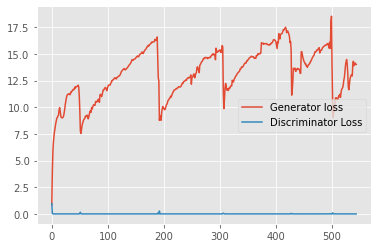

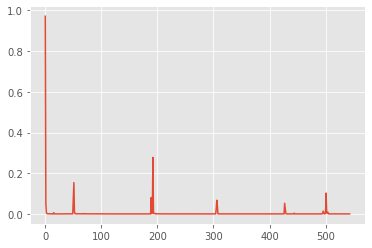

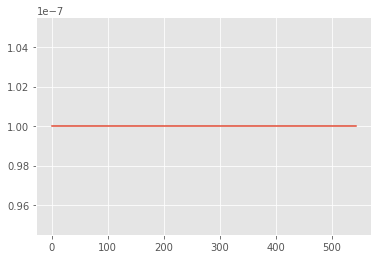

In [35]:
# plot and save the generator and discriminator loss
plt.figure()
losses_g_fixed = [i for i in losses_g]
losses_d_fixed = [i for i in losses_d]
sat_fixed = [i.detach() for i in sat]
plt.plot(losses_g_fixed, label='Generator loss')
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss_nocan_test1.png')
plt.figure()
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.savefig('./outputs/loss_d_nocan_test1.png')
plt.figure()
plt.plot(sat_fixed, label='Constraint satisfaction')
plt.savefig('./outputs/sat_nocan_test1.png')